<div align = "center">

# **Severidad**

</div>

## Librerias

In [65]:
library(dplyr)
library(ggplot2)
library(MASS)
library(car)
library(broom)
library(hnp)

## Data

In [66]:
data <- read.csv("../data/processed/tabla_severidad.csv")
data$X <- NULL

In [67]:
head(data)

,Modelo,Color,Carroceria,CLASE_FASECOLDA,TIPO_VEHICULO,SERVICIO,Sexo_Aseg,Grupo_Edad,valor,n_siniestros,exposicion_total,suma_pagos,n_observaciones,severidad_media
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
1,1993,ROJO,SEDAN,AUTOMOVIL,Livianos,Particular,F,41-63,64667906,2,1834,2558114,10,1279057
2,1993,ROJO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19-41,76728037,2,1203,4883644,7,2441822
3,1997,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,41-63,121930553,2,3077,4238816,16,2119408
4,1998,AZUL,SEDAN,AUTOMOVIL,Livianos,Particular,F,19-41,130833256,2,2791,8213167,16,4106584
5,1998,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,19-41,101517338,2,2410,8014069,13,4007035
6,1998,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19-41,180459141,4,4223,6450375,23,1612594


In [68]:
summary(data$suma_pagos)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  148662  1914583  4185008  7373264  9182684 68223671 

In [69]:
establecer_categorias_referencia <- function(df, vars_categoricas, var_exposicion = "exposicion_total") {
  df_copy <- df
  
  for (var in vars_categoricas) {
    exposicion_por_categoria <- aggregate(df_copy[[var_exposicion]], 
                                        by = list(df_copy[[var]]), 
                                        FUN = sum, na.rm = TRUE)
    names(exposicion_por_categoria) <- c("categoria", "exposicion_total")
    
    categoria_referencia <- exposicion_por_categoria$categoria[which.max(exposicion_por_categoria$exposicion_total)]
    
    cat("Variable:", var, "- Categoría de referencia:", categoria_referencia, "\n")
    
    df_copy[[var]] <- factor(df_copy[[var]])
    df_copy[[var]] <- relevel(df_copy[[var]], ref = as.character(categoria_referencia))
  }
  
  return(df_copy)
}

vars_categoricas <- c("Modelo", "Color", "Carroceria", "CLASE_FASECOLDA", 
                     "TIPO_VEHICULO", "SERVICIO", "Sexo_Aseg", "Grupo_Edad")

data <- establecer_categorias_referencia(data, vars_categoricas)

str(data)

Variable: Modelo - Categoría de referencia: 2012 
Variable: Color - Categoría de referencia: PLATA 
Variable: Carroceria - Categoría de referencia: HATCHBACK 
Variable: CLASE_FASECOLDA - Categoría de referencia: AUTOMOVIL 
Variable: TIPO_VEHICULO - Categoría de referencia: Livianos 
Variable: SERVICIO - Categoría de referencia: Particular 
Variable: Sexo_Aseg - Categoría de referencia: M 
Variable: Grupo_Edad - Categoría de referencia: 41-63 


'data.frame':	258 obs. of  14 variables:
 $ Modelo          : Factor w/ 18 levels "2012","1993",..: 2 2 3 4 4 4 4 4 4 5 ...
 $ Color           : Factor w/ 19 levels "PLATA","AMARILLO",..: 16 16 5 3 5 5 9 16 18 5 ...
 $ Carroceria      : Factor w/ 10 levels "HATCHBACK","BUS-BUSETA",..: 8 8 8 8 8 8 10 8 8 8 ...
 $ CLASE_FASECOLDA : Factor w/ 7 levels "AUTOMOVIL","AUTOMOVIL TAXI",..: 1 1 1 1 1 1 5 1 1 1 ...
 $ TIPO_VEHICULO   : Factor w/ 2 levels "Livianos","Pesados": 1 1 1 1 1 1 1 1 1 1 ...
 $ SERVICIO        : Factor w/ 3 levels "Particular","Publico",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Sexo_Aseg       : Factor w/ 2 levels "M","F": 2 1 1 2 2 1 2 2 1 2 ...
 $ Grupo_Edad      : Factor w/ 3 levels "41-63","19-41",..: 1 2 1 2 2 2 1 1 2 1 ...
 $ valor           : num  6.47e+07 7.67e+07 1.22e+08 1.31e+08 1.02e+08 ...
 $ n_siniestros    : int  2 2 2 2 2 4 2 2 2 2 ...
 $ exposicion_total: int  1834 1203 3077 2791 2410 4223 1099 1832 2197 2395 ...
 $ suma_pagos      : num  2558114 4883644 4238816 821

# **Gamma log**

## Seleccion de variables

Start:  AIC=23063.71
suma_pagos ~ log(valor) + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad + offset(log(exposicion_total))



Gamma model 


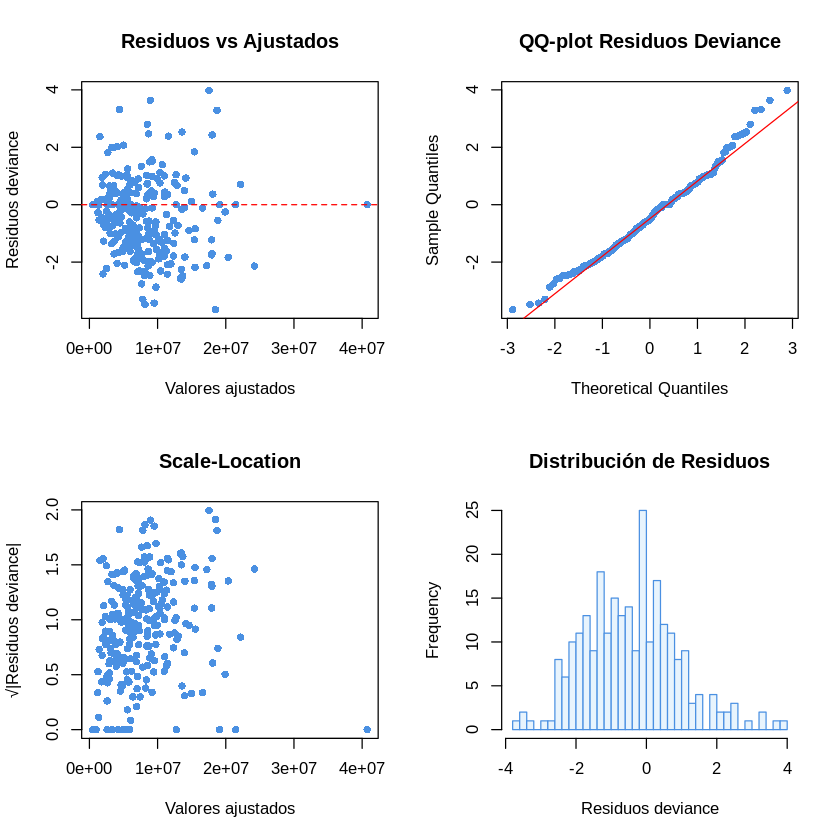

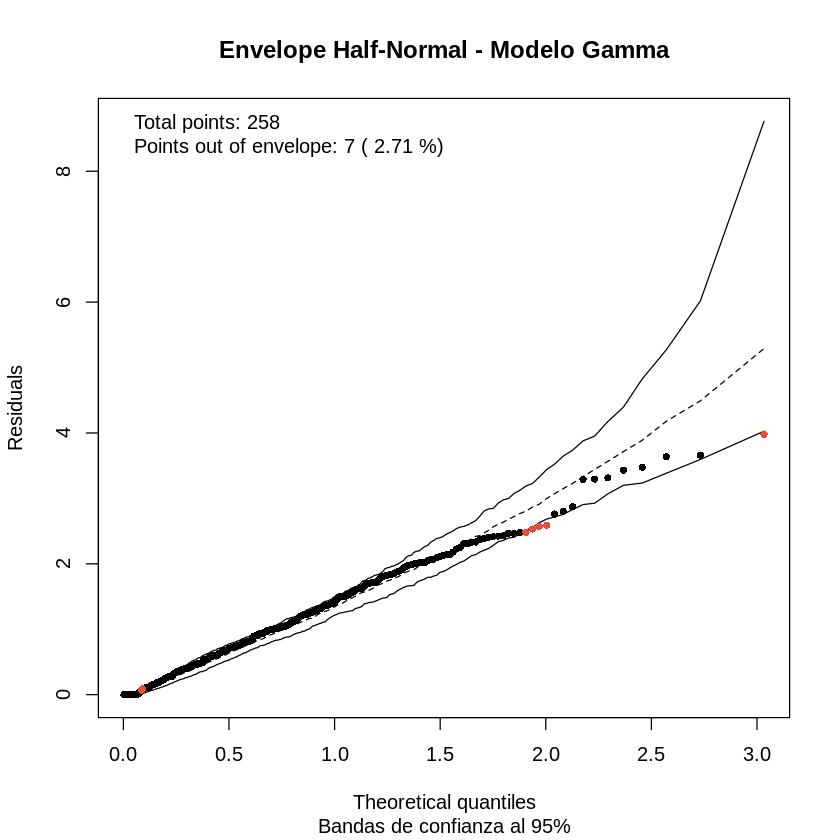

In [70]:
# Modelo completo de severidad
modelo_sev_completo <- glm(
  suma_pagos ~ log(valor) + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
               TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad + offset(log(exposicion_total)),
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)

# Modelo nulo de severidad
modelo_sev_nulo <- glm(
  suma_pagos ~ 1,
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)

# Stepwise
modelo_severidad_gamma <- step(
  modelo_sev_completo,
  scope = list(lower = modelo_sev_nulo, upper = modelo_sev_completo),
  direction = "forward",
  trace = TRUE
)

# 1. Extraer residuos básicos
residuos_deviance <- residuals(modelo_severidad_gamma, type = "deviance")
residuos_pearson <- residuals(modelo_severidad_gamma, type = "pearson")
valores_ajustados <- fitted(modelo_severidad_gamma)

# 2. Panel de diagnósticos básicos (4 gráficos)
par(mfrow = c(2, 2))

# Residuos vs valores ajustados
plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados",
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

# QQ-plot de residuos
qqnorm(residuos_deviance, 
       main = "QQ-plot Residuos Deviance",
       pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

# Scale-Location
plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location",
     pch = 16, col = "#4A90E2")

# Histograma de residuos
hist(residuos_deviance, 
     breaks = 30,
     main = "Distribución de Residuos",
     xlab = "Residuos deviance",
     col = "#E8F4FD",
     border = "#4A90E2")

par(mfrow = c(1, 1))

# Envelope plot para modelo Gamma
set.seed(123)  # Para reproducibilidad

envelope_gamma <- hnp(modelo_severidad_gamma, 
                      sim = 99,           # Número de simulaciones
                      conf = 0.95,        # Nivel de confianza
                      halfnormal = TRUE,  # Gráfico half-normal
                      scale = TRUE,       # Escalar residuos
                      plot.sim = TRUE,    # Mostrar simulaciones
                      verb.sim = FALSE,   # Sin output verbose
                      how.many.out = TRUE,# Contar outliers
                      print.on = TRUE,    # Imprimir estadísticas
                      paint.out = TRUE,   # Colorear outliers
                      col.paint.out = "#E74C3C",
                      pch = 16,
                      cex = 0.8)

# Personalizar el gráfico
title("Envelope Half-Normal - Modelo Gamma", 
      sub = "Bandas de confianza al 95%")

## **Lognormal**

Start:  AIC=822.03
log(suma_pagos) ~ log(valor) + Modelo + Color + Carroceria + 
    CLASE_FASECOLDA + TIPO_VEHICULO + SERVICIO + Sexo_Aseg + 
    Grupo_Edad + offset(log(exposicion_total))




Call:
glm(formula = log(suma_pagos) ~ log(valor) + Modelo + Color + 
    Carroceria + CLASE_FASECOLDA + TIPO_VEHICULO + SERVICIO + 
    Sexo_Aseg + Grupo_Edad + offset(log(exposicion_total)), family = gaussian(link = "identity"), 
    data = data, weights = n_siniestros)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.8641  -1.1243  -0.0314   0.8544   4.5746  

Coefficients: (3 not defined because of singularities)
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            14.95702    2.65567   5.632 5.88e-08 ***
log(valor)                             -0.37971    0.12598  -3.014  0.00291 ** 
Modelo1993                             -0.31365    0.94198  -0.333  0.73950    
Modelo1997                             -0.69869    1.26337  -0.553  0.58085    
Modelo1998                             -0.27815    0.55848  -0.498  0.61899    
Modelo1999                             -0.42940    0.92756  -0.463  0.64391  

Gaussian model (glm object) 


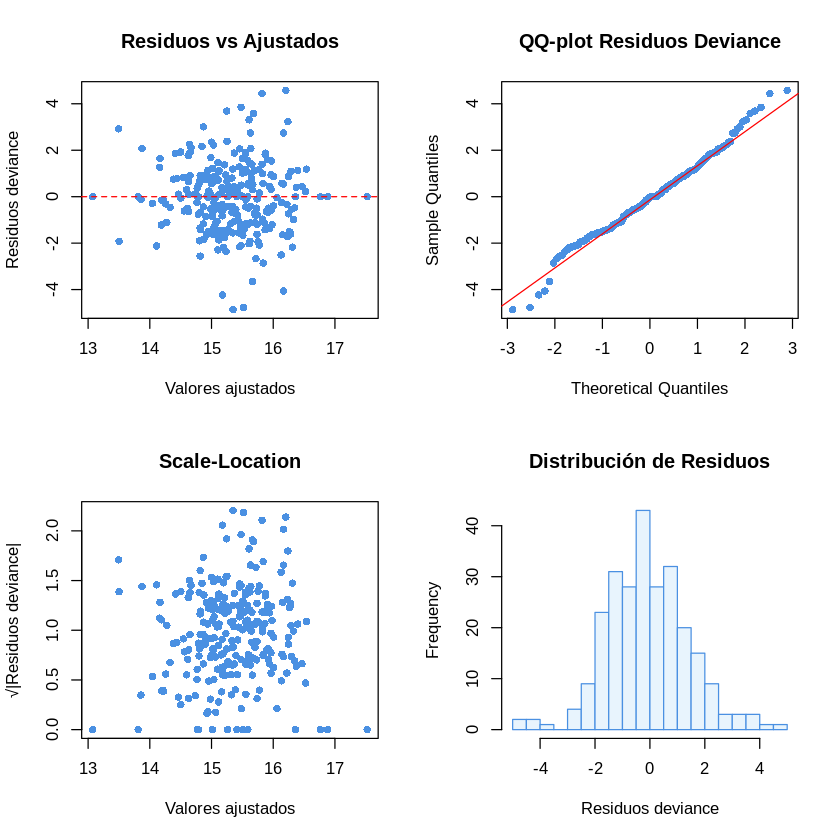

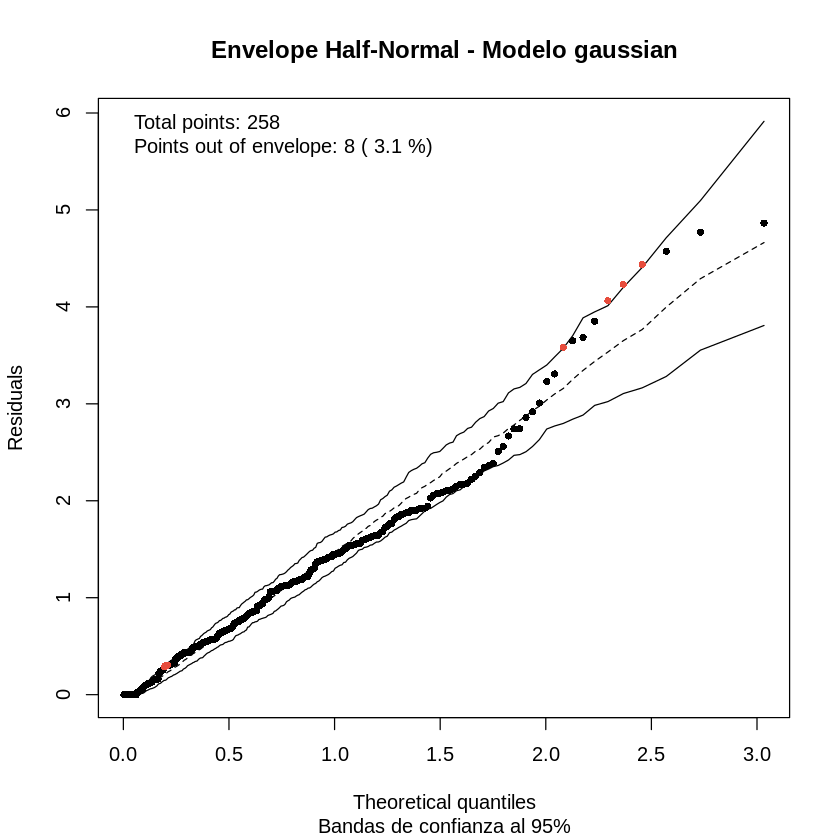

In [71]:
# Modelo completo de severidad
modelo_sev_completo <- glm(
  log(suma_pagos) ~ log(valor) + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
               TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad + offset(log(exposicion_total)),
  family = gaussian(link = "identity"),
  weights = n_siniestros,
  data = data
)

# Modelo nulo de severidad
modelo_sev_nulo <- glm(
  log(suma_pagos) ~ 1,
  family = gaussian(link = "identity"),
  weights = n_siniestros,
  data = data
)

# Stepwise
modelo_severidad_lognormal <- step(
  modelo_sev_completo,
  scope = list(lower = modelo_sev_nulo, upper = modelo_sev_completo),
  direction = "forward",
  trace = TRUE
)

summary(modelo_severidad_lognormal)

# 1. Extraer residuos básicos
residuos_deviance <- residuals(modelo_severidad_lognormal, type = "deviance")
residuos_pearson <- residuals(modelo_severidad_lognormal, type = "pearson")
valores_ajustados <- fitted(modelo_severidad_lognormal)

# 2. Panel de diagnósticos básicos (4 gráficos)
par(mfrow = c(2, 2))

# Residuos vs valores ajustados
plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados",
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

# QQ-plot de residuos
qqnorm(residuos_deviance, 
       main = "QQ-plot Residuos Deviance",
       pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

# Scale-Location
plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location",
     pch = 16, col = "#4A90E2")

# Histograma de residuos
hist(residuos_deviance, 
     breaks = 30,
     main = "Distribución de Residuos",
     xlab = "Residuos deviance",
     col = "#E8F4FD",
     border = "#4A90E2")

par(mfrow = c(1, 1))

# Envelope plot para modelo gaussian
set.seed(123)  # Para reproducibilidad

envelope_gaussian <- hnp(modelo_severidad_lognormal, 
                      sim = 99,           # Número de simulaciones
                      conf = 0.95,        # Nivel de confianza
                      halfnormal = TRUE,  # Gráfico half-normal
                      scale = TRUE,       # Escalar residuos
                      plot.sim = TRUE,    # Mostrar simulaciones
                      verb.sim = FALSE,   # Sin output verbose
                      how.many.out = TRUE,# Contar outliers
                      print.on = TRUE,    # Imprimir estadísticas
                      paint.out = TRUE,   # Colorear outliers
                      col.paint.out = "#E74C3C",
                      pch = 16,
                      cex = 0.8)

# Personalizar el gráfico
title("Envelope Half-Normal - Modelo gaussian", 
      sub = "Bandas de confianza al 95%")

## Exportando

In [74]:
  # Guardar el modelo de severidad final
  saveRDS(modelo_severidad_gamma, file = "../models/modelo_severidad_gamma.rds")

  # Opcional: También guardar información adicional del modelo
  modelo_info <- list(
    modelo = modelo_severidad_gamma,
    aic = AIC(modelo_severidad_gamma),
    formula = formula(modelo_severidad_gamma),
    family = "Gamma",  # "Gamma" o "Log-Normal"
    fecha_entrenamiento = Sys.Date()
  )

  saveRDS(modelo_info, file = "../models/modelo_severidad_gamma_completo.rds")

In [75]:
  # Guardar el modelo de severidad final
  saveRDS(modelo_severidad_lognormal, file = "../models/modelo_severidad_lognormal.rds")

  # Opcional: También guardar información adicional del modelo
  modelo_info <- list(
    modelo = modelo_severidad_lognormal,
    aic = AIC(modelo_severidad_lognormal),
    formula = formula(modelo_severidad_lognormal),
    family = "lognormal",  # "lognormal" o "Log-Normal"
    fecha_entrenamiento = Sys.Date()
  )

  saveRDS(modelo_info, file = "../models/modelo_severidad_lognormal_completo.rds")